In [1]:

import time
start_time=time.time()
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import linmix
from scipy.stats import pearsonr
import math
import itertools
import json
from logerr import logify
from results import loadresults


sns.set_context("talk")

Load Results and errors

In [2]:
res = loadresults()
res

,Region,sig2 [km/s],sig2er,sig [km/s],siger,m,mer,r0 [pc],r0er
0,Orion,12.648003,0.742833,3.556403,0.208872,1.073374,0.031151,0.067959,0.006121
1,M8,7.385188,1.242835,2.717570,0.457333,1.263906,0.176361,1.034714,0.236500
2,Carina,18.137617,1.393893,4.258828,0.327295,1.158353,0.276279,0.550457,0.082150
3,30 Dor,297.536688,39.611347,17.249252,2.296410,0.851961,0.077782,3.857852,1.064497
4,NGC 346,33.022801,2.568073,5.746547,0.446890,0.956389,0.047801,2.373683,0.293811
5,Hubble X,14.812259,2.672278,3.848670,0.694338,1.016097,0.080615,4.099418,0.325858
6,Hubble V,9.824044,3.534439,3.134333,1.127653,0.810433,0.093346,3.561965,0.451416
7,NGC 595,53.206356,4.643371,7.294269,0.636578,1.376368,0.087961,11.211662,0.739236
8,NGC 604,85.868750,20.418004,9.266539,2.203412,0.775075,0.207397,12.087616,6.443078


In [3]:
sig = res['sig [km/s]']
sig_er = res['siger']
X = logify(sig, sig_er)[0]
Xe = logify(sig, sig_er)[1]

Luminosity values from literature

1. Kennicut 1984: https://articles.adsabs.harvard.edu//full/1984ApJ...287..116K/0000122.000.html 
2. \
Orion : \
Carina : \
Smith & Brooks 2007 https://academic.oup.com/mnras/article/379/4/1279/996059
30 Dor : \
Bestenleher et al https://academic.oup.com/mnras/article/499/2/1918/5905414 \
M8,346: \
Kennicut 1984 https://articles.adsabs.harvard.edu//full/1984ApJ...287..116K/0000122.000.html \
HX,HV,N604,N595: \
Bosch et al. 2002 Table 11- https://academic.oup.com/mnras/article/329/3/481/1031037


In [4]:
L_data=pd.DataFrame()
L_data['Region'] = ['Orion','M8','Carina','30 Dor','346','H X', 'H V', '595', '604']
L_data['L(Ha) [erg/s]$^1$'] = [1e37,3e37,6e38,1.5e40,6e38,4e38,7.5e38,2.3e39,4.5e39]
L_data['log L(Ha)$^1$ [erg/s]'] = np.log10(L_data['L(Ha) [erg/s]$^1$'] )
L_data['log L(Ha)$^2$ [erg/s]'] = [37.18,37.47,39.01,39.46,38.77,38.21,38.3,38.95,39.42]
L_data['log Q(H)$^2$ [photos/s]'] = [49.12,0,50.95,51.4,0,0,0,0,0]
L_data['conv_fact']=(10**L_data['log Q(H)$^2$ [photos/s]'])/(10**L_data['log L(Ha)$^2$ [erg/s]'])
L_data['log L(Ha)$^3$ [erg/s]'] = (L_data['log L(Ha)$^1$ [erg/s]']+L_data['log L(Ha)$^2$ [erg/s]'])/2

L_data.round(2)

,Region,L(Ha) [erg/s]$^1$,log L(Ha)$^1$ [erg/s],log L(Ha)$^2$ [erg/s],log Q(H)$^2$ [photos/s],conv_fact,log L(Ha)$^3$ [erg/s]
0,Orion,1.000000e+37,37.00,37.18,49.12,8.709636e+11,37.09
1,M8,3.000000e+37,37.48,37.47,0.00,0.000000e+00,37.47
2,Carina,6.000000e+38,38.78,39.01,50.95,8.709636e+11,38.89
3,30 Dor,1.500000e+40,40.18,39.46,51.40,8.709636e+11,39.82
4,346,6.000000e+38,38.78,38.77,0.00,0.000000e+00,38.77
5,H X,4.000000e+38,38.60,38.21,0.00,0.000000e+00,38.41
6,H V,7.500000e+38,38.88,38.30,0.00,0.000000e+00,38.59
7,595,2.300000e+39,39.36,38.95,0.00,0.000000e+00,39.16
8,604,4.500000e+39,39.65,39.42,0.00,0.000000e+00,39.54


[Text(0, 0.5, 'Log(L$_{Hα}$) [erg/s]'),
 Text(0.5, 0, '$σ_{pos}$ [km s$^{-1}$]')]

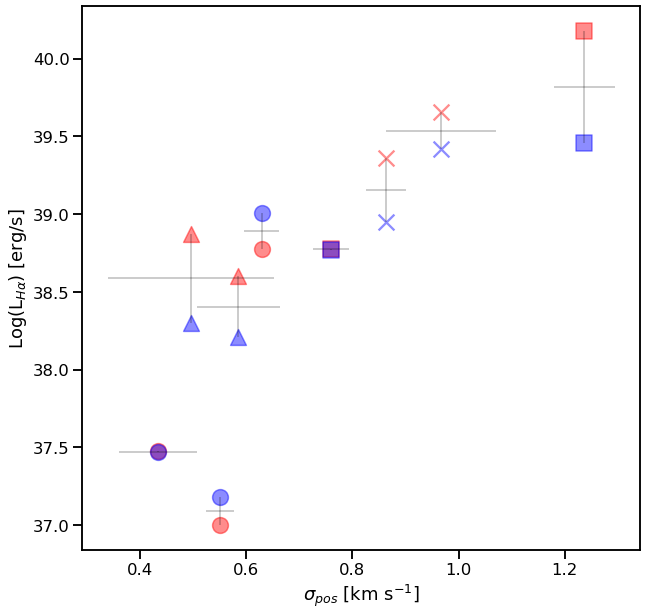

In [5]:
Y1 = L_data['log L(Ha)$^1$ [erg/s]']
Y1e = logify(Y1, Y1*.1)[1]
Y2 = L_data['log L(Ha)$^2$ [erg/s]']
Y2e = logify(Y2, Y2*.1)[1]
Y3 = L_data['log L(Ha)$^3$ [erg/s]']
Y3e = Y3-Y1

fig, ax = plt.subplots(figsize=(10,10))
ax.errorbar(X, Y3, xerr=Xe, yerr=Y3e, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

marker=itertools.cycle(('o','o','o','s','s','^','^','x','x'))
for i in range(len(L_data)):
    ax.scatter(X[i], Y1[i], marker=next(marker), s=250,zorder=0, c ='r', alpha=0.45)
for i in range(len(L_data)):    
    ax.scatter(X[i], Y2[i], marker=next(marker), s=250,zorder=0, c ='b', alpha=0.45)
#for i in range(len(L_data)):    
#    ax.scatter(X[i], Y3[i], marker=next(marker), s=250,zorder=0, c ='purple', alpha=0.65)
    
ax.set(ylabel='Log(L$_{Hα}$) [erg/s]', xlabel='$σ_{pos}$ [km s$^{-1}$]')

In [6]:
Y=Y3
Ye=Y3e
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)
lm.run_mcmc(silent=True)

dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)

[(37.0, 40.0),
 Text(0, 0.5, 'log L(H) [erg s^-1]'),
 (0.2, 1.35),
 Text(0.5, 0, 'log $\\sigma$ [km/s]')]

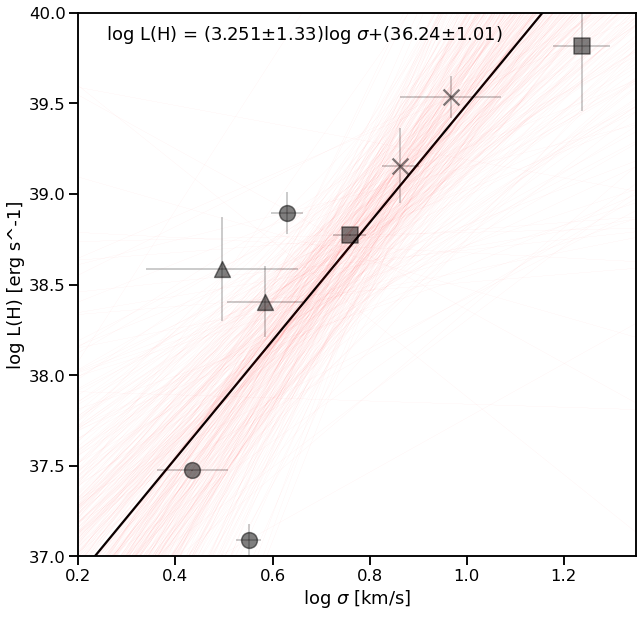

In [7]:
vmin, vmax = 0.2, 1.4
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

marker=itertools.cycle(('o','o','o','s','s','^','^','x','x'))
#for i in [0,1,2,3,4,6,8]:
for i in range(len(L_data)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)

# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::25]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log L(H) = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $\sigma$+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    ylim=[37, 40], xlim=[0.2, 1.35],
    ylabel=r"log L(H) [erg s^-1]", xlabel=r"log $\sigma$ [km/s]",
)

In [8]:
['log L(H)','log $\sigma$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y3)[0],2),np.round(pearsonr(X, Y3)[1],3)]

['log L(H)', 'log $\\sigma$', 3.25, 1.33, 36.24, 1.01, 0.83, 0.006]

Change variables

In [9]:
lm = linmix.LinMix(Y, X, Ye, Xe, K=2)
lm.run_mcmc(silent=True)

dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
['log L(H)','log $\sigma$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(Y, X)[0],2),np.round(pearsonr(Y, X)[1],3)]

['log L(H)', 'log $\\sigma$', 0.23, 0.09, -8.11, 3.63, 0.83, 0.006]

Other L

In [10]:
lm = linmix.LinMix(X, Y1, Xe, Y1e, K=2)
lm.run_mcmc(silent=True)

dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
['log L(H)','log $\sigma$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y1)[0],2),np.round(pearsonr(X, Y1)[1],3)]

['log L(H)', 'log $\\sigma$', 3.57, 1.36, 36.11, 1.05, 0.82, 0.007]

In [11]:
lm = linmix.LinMix(X, Y2, Xe, Y2e, K=2)
lm.run_mcmc(silent=True)

dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
['log L(H)','log $\sigma$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y2)[0],2),np.round(pearsonr(X, Y2)[1],3)]

['log L(H)', 'log $\\sigma$', 2.68, 1.22, 36.57, 0.94, 0.81, 0.008]

+Previous work

In [12]:
path_previous = 'data-previous-scaling-relations'

Fer=pd.read_csv(path_previous+'//Fernandez2018.csv')


In [13]:
#sig = res['sig [km/s]']
#sig_er = res['siger']
#X = logify(sig, sig_er)[0]
#Xe = logify(sig, sig_er)[1]
#siglos_er=sig*(1.03)+7.3

In [14]:
siglos=sig*(1.03)+7.3
siglos_er=(sig_er/sig)*siglos
X2 = logify(siglos, siglos_er)[0]
X2e = logify(siglos, siglos_er)[1]

In [15]:
Y3b=Y3-0.44

In [16]:
lm = linmix.LinMix(X2, Y3b, X2e, Y3e, K=2)
lm.run_mcmc(silent=True)

dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
['log L(H)','log $\sigma$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X2, Y3)[0],2),np.round(pearsonr(X2, Y3)[1],3)]

['log L(H)', 'log $\\sigma$', 7.11, 4.01, 30.17, 4.51, 0.79, 0.011]

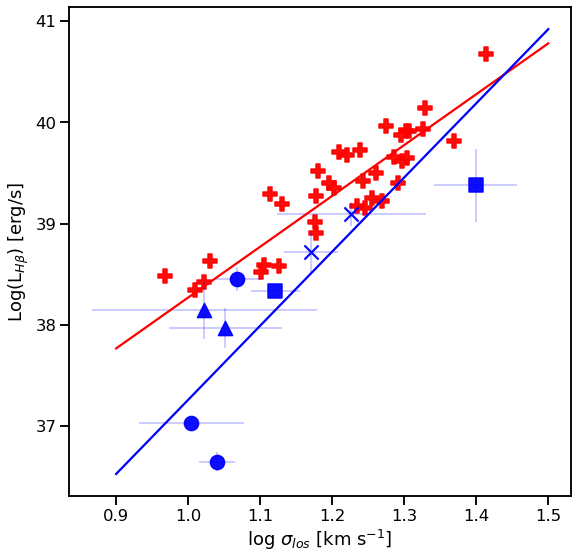

In [17]:
fig, ax=plt.subplots(figsize=(9,9))


plt.scatter(Fer.sig,Fer.L,label='Fernandez 2018',marker='P',alpha=0.95,color='red',s=200)

marker=itertools.cycle(('o','o','o','s','s','^','^','x','x'))
for i in range(len(L_data)):
    ax.scatter(X2[i], Y3b[i], marker=next(marker), label='This work',alpha=0.95,color='blue',s=200)
    
ax.errorbar(X2, Y3b, xerr=X2e, yerr=Y3e, ls=" ", elinewidth=0.4, alpha=1.0, c="b")


#plt.yscale('log')
ax.set(ylabel='Log(L$_{Hβ}$) [erg/s]', xlabel='log $σ_{los}$ [km s$^{-1}$]')

vmin, vmax = 0.9, 1.5
xgrid = np.linspace(vmin, vmax, 200)
ax.plot(xgrid, (33.25) + xgrid*(5.02), '-', c="r")
ax.plot(xgrid, (29.94) + xgrid*(7.32), '-', c="b")



#ax.text(.05, .95,'log L(H) = (' 
#        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
#        + ')log $\sigma$+('
#        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
#        + ')',  color='k', transform=ax.transAxes)

#plt.legend()
#ax.set(
#    ylim  = [37.5, 42],
#    xlim  = [0.9, 1.5],
#)

In [18]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 31.22255825996399 seconds ---


In [19]:
!jupyter nbconvert --to script --no-prompt luminosity-H.ipynb

[NbConvertApp] Converting notebook luminosity-H.ipynb to script
[NbConvertApp] Writing 7293 bytes to luminosity-H.py
